In [33]:
import os
import torch
import numpy as np
from torchvision import transforms, datasets
import torchvision
import matplotlib.pyplot as plt

In [34]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [35]:
NAME_MAP = {'banana': '香蕉皮', 'battery': '电池', 'cake': '蛋糕', 'calendar': '台历', 'fan': '风扇', 'glass': '玻璃',
            'medicine': '弃置药品', 'metal': '金属', 'nailcolor': '指甲油', 'napkin': '纸巾', 'plastic': '塑料', 'quilt': '被子', 
            'rice': '残渣剩饭', 'teamilk': '奶茶杯', 'tube': '灯管'}
TRASH_MAP = {'banana': '易腐垃圾', 'battery': '有害垃圾', 'cake': '易腐垃圾', 'calendar': '可回收垃圾', 'fan': '可回收垃圾', 
             'glass': '可回收垃圾', 'medicine': '有害垃圾', 'metal': '可回收垃圾', 'nailcolor': '有害垃圾', 'napkin': '其他垃圾', 
             'plastic': '可回收垃圾', 'quilt': '可回收垃圾', 'rice': '易腐垃圾', 'teamilk': '其他垃圾', 'tube': '有害垃圾'}
COLOR_MAP = {'可回收垃圾': 'b', '有害垃圾': 'r', '易腐垃圾': 'g', '其他垃圾': 'gray'}

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [37]:
data_dir = 'datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, 
                                             num_workers=4) for x in ['train', 'val']}

In [38]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [39]:
device = torch.device('cpu')

In [40]:
model_ft = torchvision.models.mobilenet_v2(pretrained=False)
model_ft.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(model_ft.last_channel, 15),)

In [41]:
model_ft.load_state_dict(torch.load('trash_classifier_model.pth'))

<All keys matched successfully>

In [42]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp * std + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [43]:
def visualize_result(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8, 6), dpi=150)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('预测：{0}-{1}'.format(NAME_MAP[class_names[preds[j]]], TRASH_MAP[class_names[preds[j]]]), 
                                                  c=COLOR_MAP[TRASH_MAP[class_names[preds[j]]]])
                imshow(inputs[j].cpu())
                
                if images_so_far == num_images:
                    plt.savefig('result.png')
                    model.train(mode=was_training)
                    return

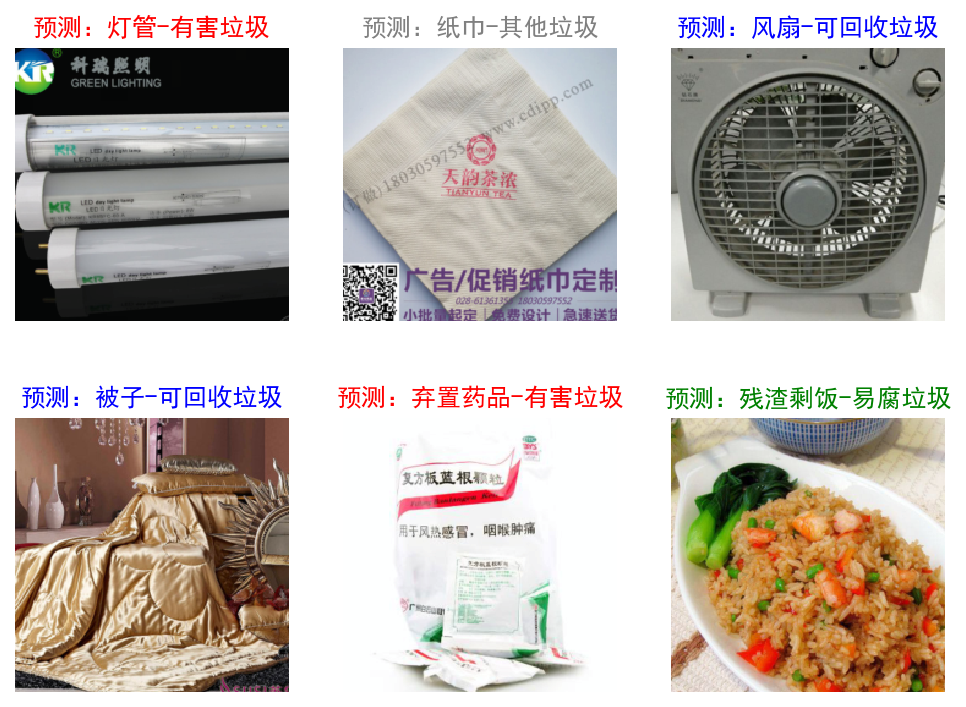

In [61]:
visualize_result(model_ft)